# Exploration Analysis

This notebook aims at trying to better understand the most important features in the best performing model. We start by importing useful libraries:

In [3]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import random
import pingouin as pg
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, make_scorer, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

We first start by loading our dataset:

In [4]:
df=pd.read_csv('aggr_data.csv')
X=df[['qd1', 'AREA5', 'qd7', 'qd9', 'qd10', 'fin_knowledge_score', 'Debtor', 'Perc_Fin_Lit', 'Saver_Spender','Planner_Easygoer', 'Fin_Products_Experience', 'Fin_Indipendence', 'Approach_Digitalised', 'defrauded']]
y=df['defrauded']

We also intialise a feature dict to change features' name for readability

In [5]:
feature_dict={}
feature_dict['qd1']='Gender'
feature_dict['AREA5']='Geographic area'
feature_dict['qd7']='Age'
feature_dict['qd9']='Education'
feature_dict['qd10']='Employment status'
feature_dict['fin_knowledge_score']='Financial knowledge'
feature_dict['Debtor']='Indebtment'
feature_dict['Perc_Fin_Lit']='Perceived financial knowledge'
feature_dict['Saver_Spender']='Saving attitude'
feature_dict['Planner_Easygoer']='Planning attitude'
feature_dict['Fin_Products_Experience']='Financial products experience'
feature_dict['Approach_Digitalised']='Digitalisation'
feature_dict['Fin_Indipendence']='Independent financial approach'

As a first analysis we can take a look at raw correlation and partial correlation matrices; just a simple check to see which variables of our aggregated dataset are actually correlated both with the target variable and within themselves.

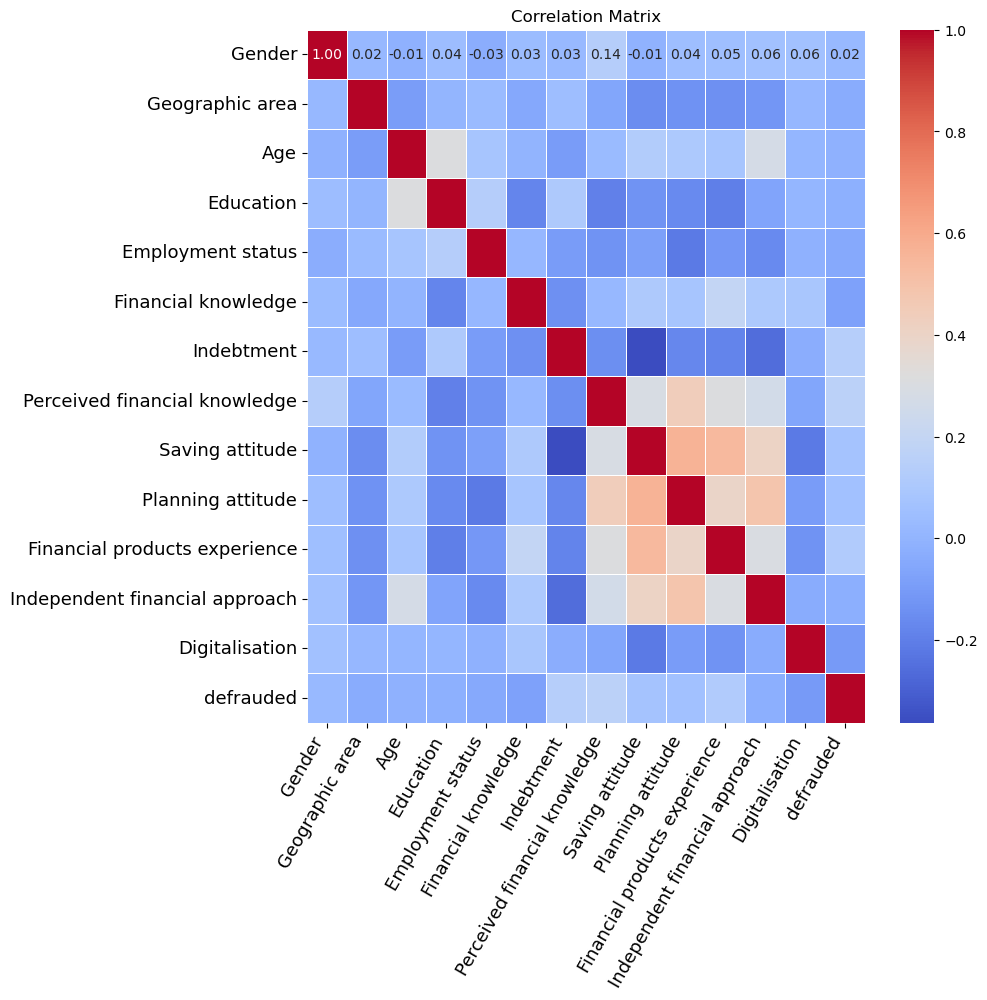

In [6]:
corr_matrix=X.corr()

corr_matrix = corr_matrix.rename(columns=feature_dict, index=feature_dict)

plt.figure(figsize=(9, 9))
heatmap=sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=60, horizontalalignment='right', fontsize=13)  
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=13)  
plt.savefig('Corrplot.png', dpi=300,  bbox_inches='tight')
plt.show()

In [7]:
partial_corr_matrix=pd.DataFrame(index=X.columns, columns=X.columns)

for i in X.columns:
    for j in X.columns:
        if i!=j:
            pcorr=pg.partial_corr(data=X, x=i, y=j, covar=[col for col in X.columns if col not in [i, j]])
            partial_corr_matrix.loc[i, j]=pcorr['r'].values[0]
        else:
            partial_corr_matrix.loc[i, j]=np.nan 

partial_corr_matrix=partial_corr_matrix.astype(float)

partial_corr_matrix = partial_corr_matrix.rename(columns=feature_dict, index=feature_dict)

/Users/carloarpini/anaconda3/envs/LMDS/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


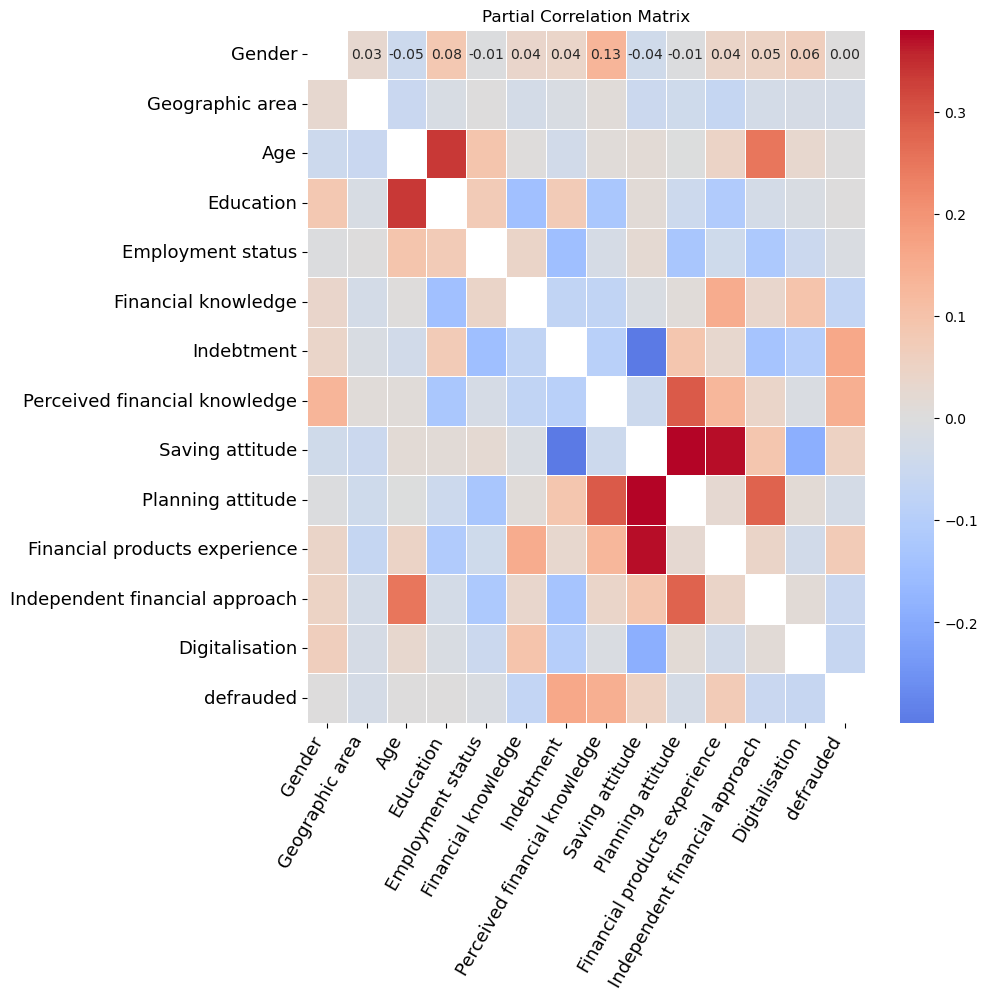

In [8]:
plt.figure(figsize=(9, 9))
heatmap=sns.heatmap(partial_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, center=0)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=60, horizontalalignment='right', fontsize=13)  
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=13)  
plt.title('Partial Correlation Matrix')
plt.savefig('parcorrplot.png', dpi=300,  bbox_inches='tight')
plt.show()

Some results that we can see based only on partial correlations are, for example, that financial independence is in general positively correlated with age and with being a planner; being a saver is in general positively correlated with having some experience with financial products and also with being a planner; also, education and age are strongly positively correlated. At last we can also observe that being a saver is negatively correlated with the presence of debt. 

Taking a look at our raw correlation matrix instead what can be seen is that our newly constructed features have less colors than others within themselves: this indicates they should be mostly linearly independent within themselves taking into account all the others.

## Model Analysis

Now we take a look at importances of each feature within the model:

First things first, we recreate our best model:

In [9]:
warnings.filterwarnings('ignore')
X.drop('defrauded', axis=1, inplace=True)

In [10]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=564, stratify=y) # 80-20 train test split, stratified to combat class imbalances

In [11]:
undersampler=RandomUnderSampler(random_state=564)
X_train_under, y_train_under=undersampler.fit_resample(X_train, y_train)

In [12]:
rf_model=RandomForestClassifier(class_weight='balanced', random_state=564)
rf_model.fit(X_train_under, y_train_under)

RandomForestClassifier(class_weight='balanced', random_state=564)

It is to be noted that this model is particularly lucky since it achieves an MCC and AUC as below: 


In [13]:
y_pred=rf_model.predict(X_test)
mcc=matthews_corrcoef(y_test, y_pred)
mcc_scorer=make_scorer(matthews_corrcoef)
cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=564)
rf_scores=cross_val_score(rf_model, X_train_under, y_train_under, cv=cv, scoring=mcc_scorer)
print(f"Random Forest Mean MCC: {rf_scores.mean()}")

Random Forest Mean MCC: 0.42491558824570835


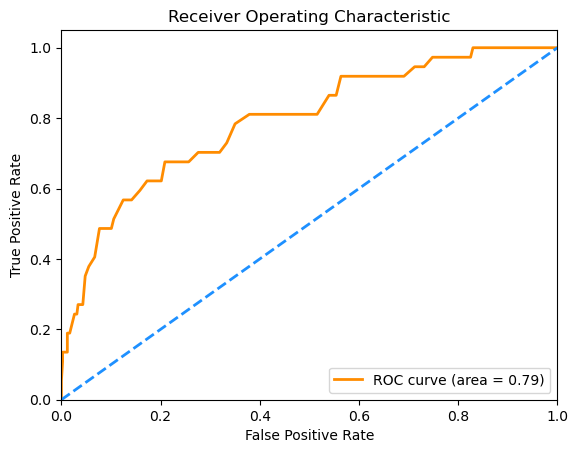

In [14]:
y_prob=rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds=roc_curve(y_test, y_prob)
roc_auc=auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='dodgerblue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Feature Importance

Then we can check a simple feature importance considering Gini entropy decrease:

Feature ranking:
1. Feature Debtor (0.15599785759732326)
2. Feature Perc_Fin_Lit (0.13129416335986716)
3. Feature Saver_Spender (0.1091595801871826)
4. Feature Planner_Easygoer (0.105380929314083)
5. Feature Fin_Products_Experience (0.10269071598992113)
6. Feature fin_knowledge_score (0.09875837153983284)
7. Feature Fin_Indipendence (0.08085178846821532)
8. Feature qd7 (0.05209149142291636)
9. Feature Approach_Digitalised (0.045938104221152555)
10. Feature qd10 (0.04202495329145714)
11. Feature qd9 (0.030497123765593125)
12. Feature AREA5 (0.02562204925411905)
13. Feature qd1 (0.019692871588336262)


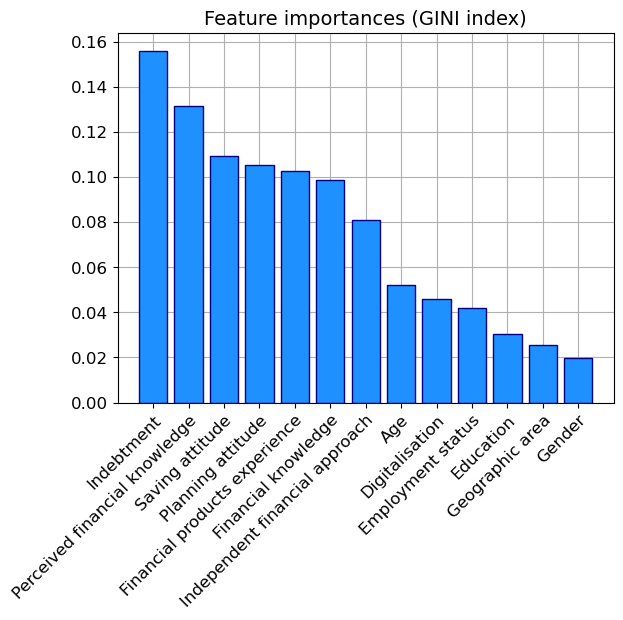

In [15]:
importances=rf_model.feature_importances_
indices=np.argsort(importances)[::-1]

print("Feature ranking:")

for i in range(X.shape[1]):
    print(f"{i + 1}. Feature {X.columns[indices[i]]} ({importances[indices[i]]})")


plt.figure()
plt.title("Feature importances (GINI index)", fontsize=14)
plt.bar(range(X.shape[1]), importances[indices], color="dodgerblue", edgecolor='navy', align="center")
plt.xticks(range(X.shape[1]), [feature_dict[X.columns[i]] for i in indices], rotation=45, rotation_mode='anchor', ha='right')
plt.xlim([-1, X.shape[1]])
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('Gini_importance.png', dpi=300,  bbox_inches='tight')
plt.show()


Let's double check with a permutation importance: 

In [16]:
mcc_scorer=make_scorer(matthews_corrcoef)
result=permutation_importance(rf_model, X_test, y_test, 
                                scoring=mcc_scorer, 
                                n_repeats=500, 
                                random_state=564, 
                                n_jobs=-1)

Feature: Perceived financial knowledge, Importance: 0.0608, Std: 0.0298
Feature: Indebtment, Importance: 0.0607, Std: 0.0351
Feature: Education, Importance: 0.0112, Std: 0.0110
Feature: Planning attitude, Importance: 0.0102, Std: 0.0154
Feature: Financial products experience, Importance: 0.0097, Std: 0.0189
Feature: Saving attitude, Importance: 0.0089, Std: 0.0165
Feature: Employment status, Importance: 0.0081, Std: 0.0132
Feature: Digitalisation, Importance: -0.0106, Std: 0.0124
Feature: Geographic area, Importance: -0.0107, Std: 0.0155
Feature: Financial knowledge, Importance: -0.0122, Std: 0.0185
Feature: Independent financial approach, Importance: -0.0183, Std: 0.0214
Feature: Gender, Importance: -0.0189, Std: 0.0112
Feature: Age, Importance: -0.0327, Std: 0.0136


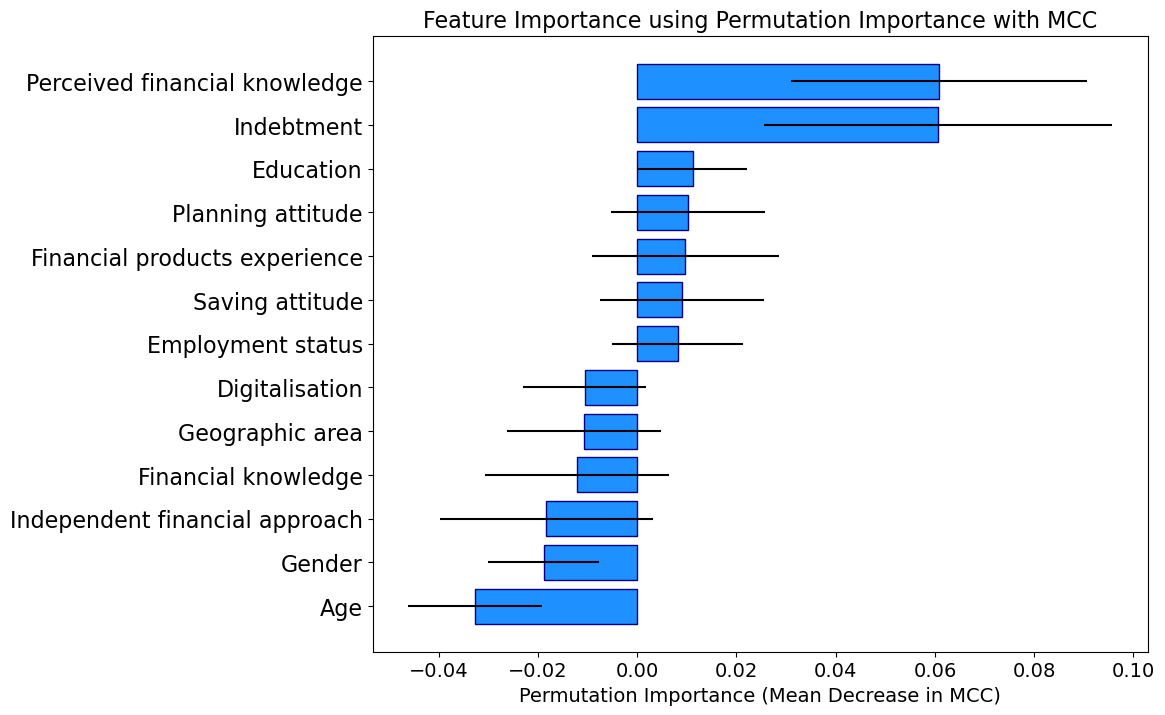

In [17]:
importances=result.importances_mean
stds=result.importances_std

for i in importances.argsort()[::-1]:
    feature_name=feature_dict.get(X_test.columns[i], X_test.columns[i])
    print(f"Feature: {feature_name}, Importance: {importances[i]:.4f}, Std: {stds[i]:.4f}")

sorted_idx=importances.argsort()

sorted_features=[feature_dict.get(col, col) for col in np.array(X_test.columns)[sorted_idx]]

plt.figure(figsize=(10, 8))
plt.barh(sorted_features, importances[sorted_idx], xerr=stds[sorted_idx], color="dodgerblue", edgecolor='navy')
plt.xlabel("Permutation Importance (Mean Decrease in MCC)", fontsize=14)
plt.title("Feature Importance using Permutation Importance with MCC", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=14)
plt.savefig('Permutation_importance.png', dpi=300,  bbox_inches='tight')
plt.show()

We can see mostly an agreement within the importances, except for the financial indipendence variable. Now let's check the impact each feature has on the target variable with Partial dependences:

### Feature Partial Dependences with Target Variable

Gender
Geographic area
Age
Education
Employment status
Financial knowledge
Indebtment
Perceived financial knowledge
Saving attitude
Planning attitude
Financial products experience
Independent financial approach
Digitalisation


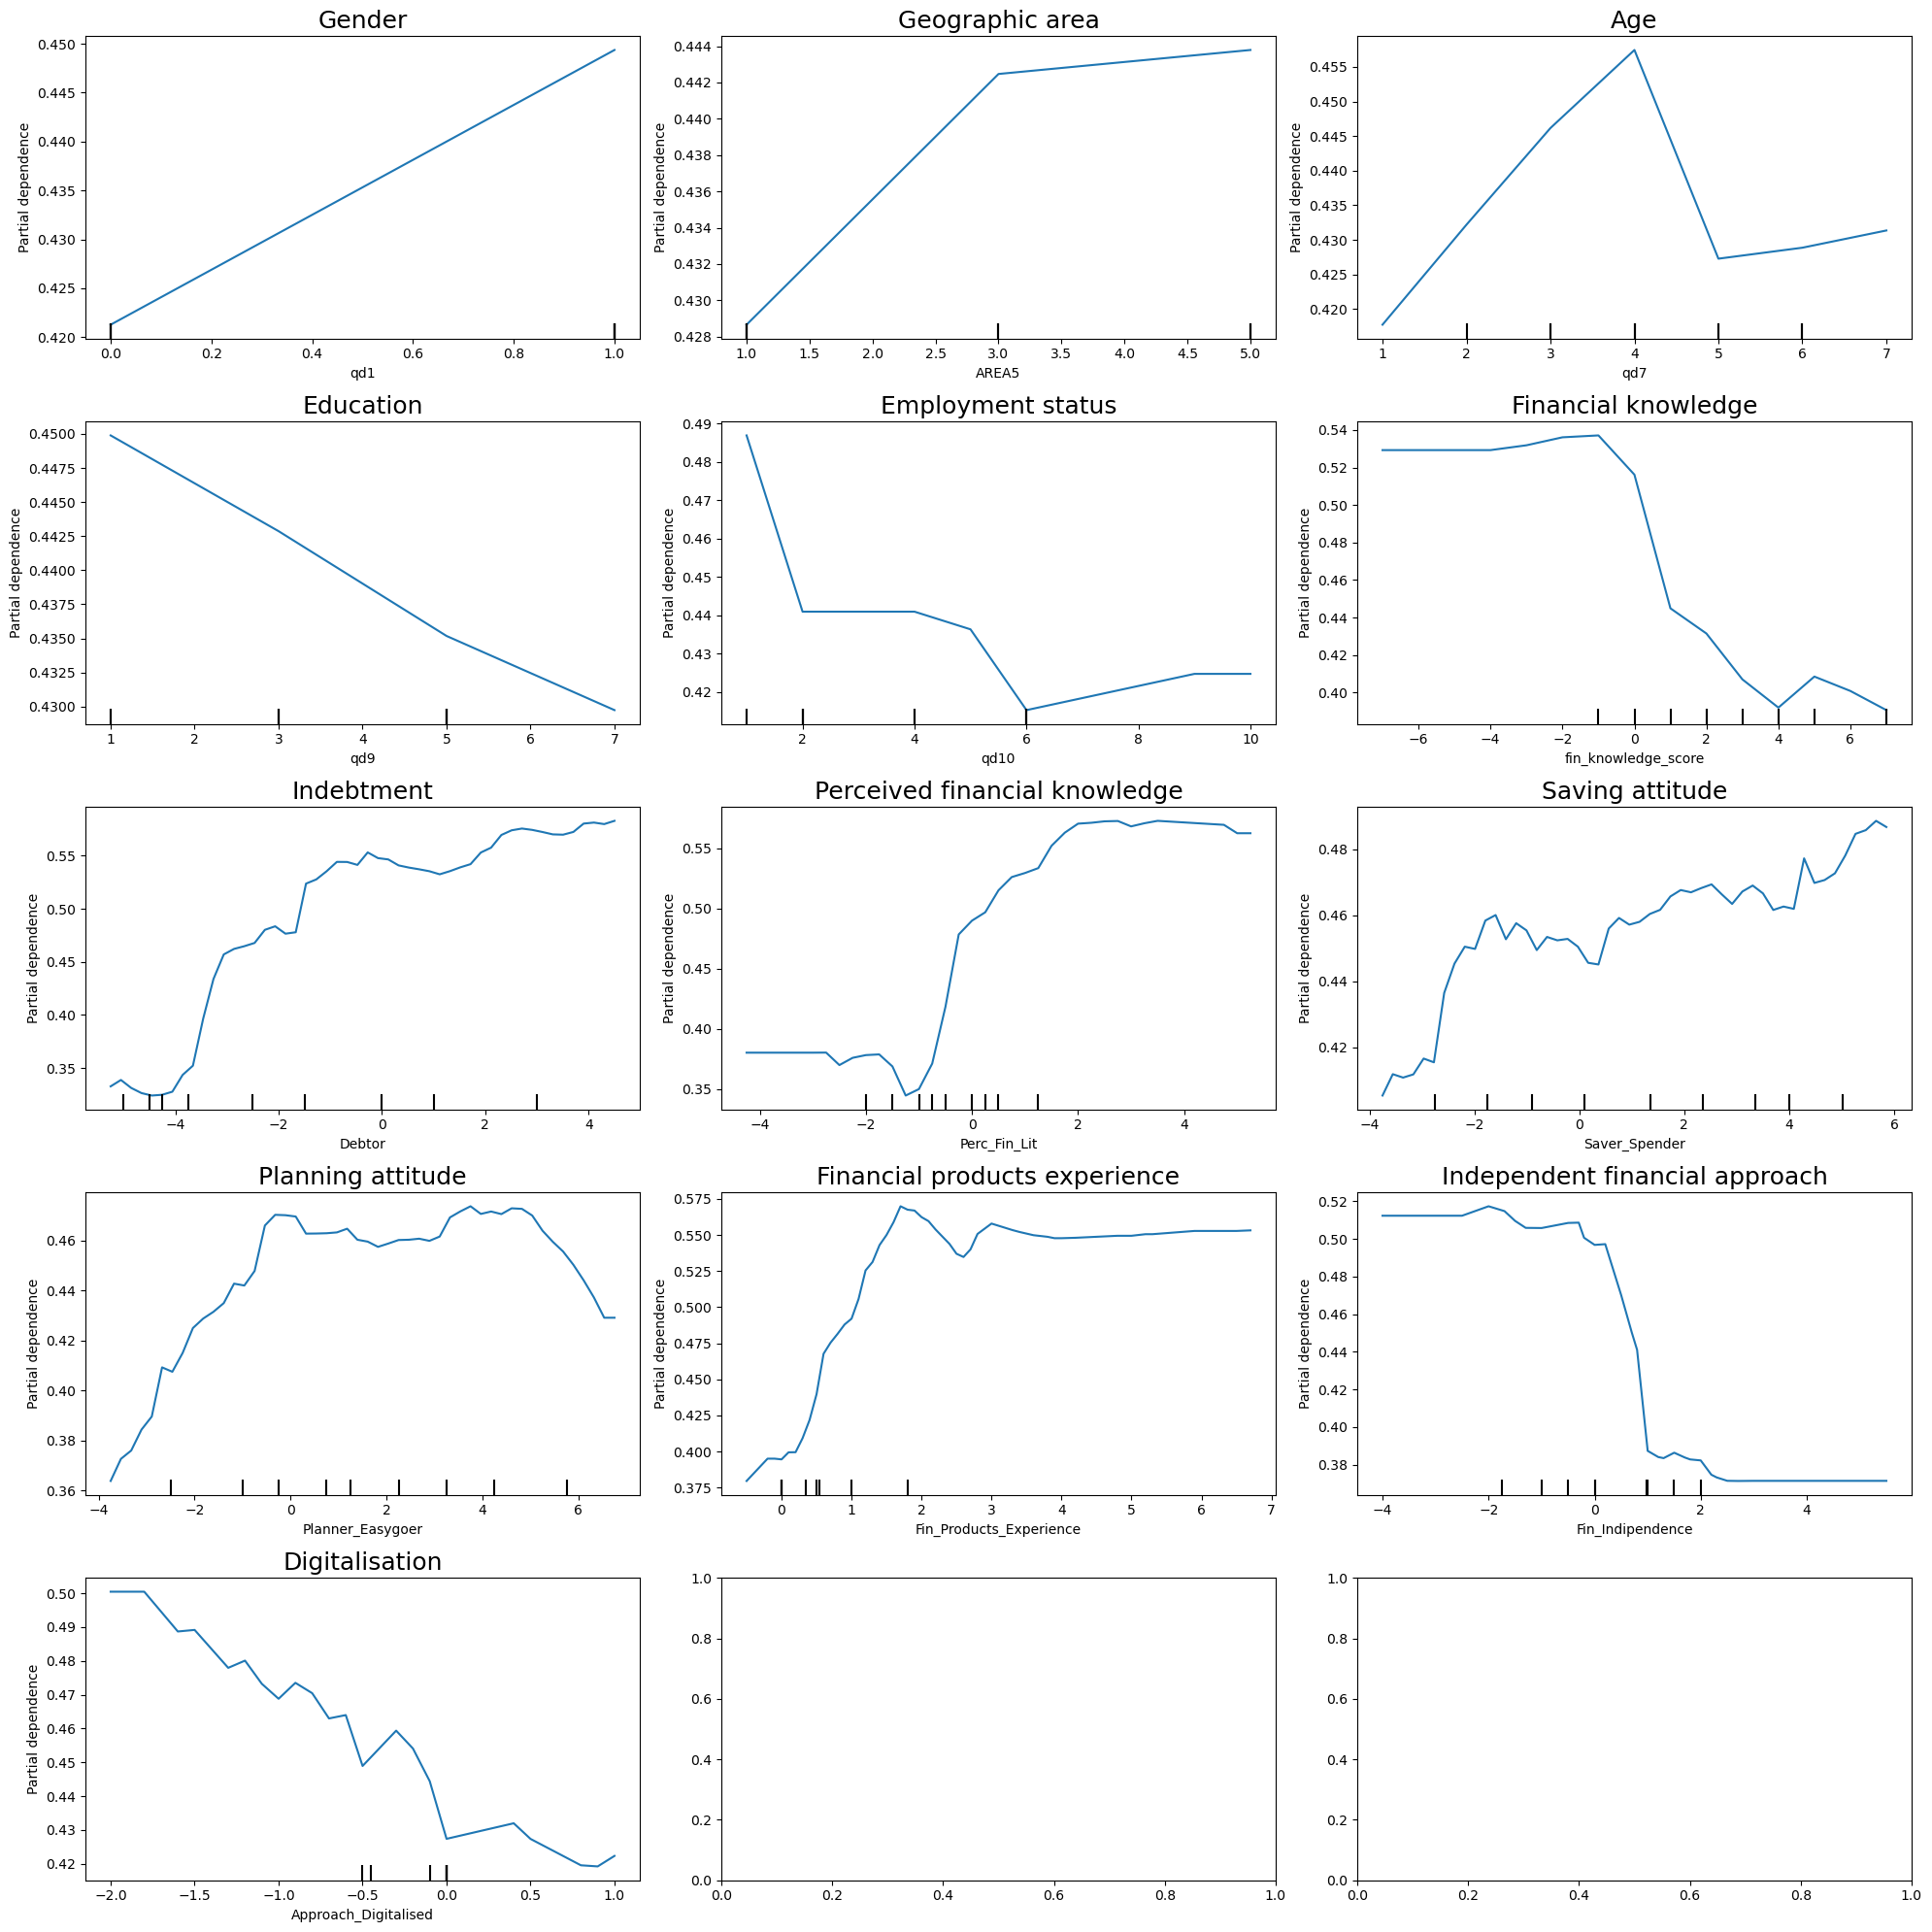

In [18]:
fig, axes=plt.subplots(5, 3, figsize=(20, 20))
axes=axes.flatten()

for i, feature in enumerate(X.columns):

    feature_name=feature_dict[feature]
    print(feature_name)

    PartialDependenceDisplay.from_estimator(estimator=rf_model,
                                            X=X_test,
                                            features=[feature],
                                            grid_resolution=50,
                                            ax=axes[i]
                                            )
    axes[i].set_title(feature_name, fontsize=18)
    for line in axes[i].get_lines():
        line.set_color('dodgerblue')
plt.tight_layout()
plt.savefig('PartialDependences.png', dpi=300,  bbox_inches='tight')
plt.show()

Surprisingly, we notice that being a fraud victim has a somewhat positive linear dependency with saving money.

### Profile Creation

One last thing we can do is try and create some "stereotypical" profiles of people who might have replied to our survey to check what is the probability of them being defrauded, to compare it to what we think. We'll create 6 different profiles to do so, as defined in the report:

In [24]:
profile_1dict={         'qd1':1, 
                        'AREA5': 1,
                        'qd7': 1,
                        'qd9': 1,
                        'qd10': 2,
                        'fin_knowledge_score': -4,
                        'Debtor': -4, 
                        'Perc_Fin_Lit': 1, 
                        'Saver_Spender': 11, 
                        'Planner_Easygoer': 7,
                        'Fin_Products_Experience': 5, 
                        'Fin_Indipendence': 5,
                        'Approach_Digitalised': -2 }
Profile1=pd.DataFrame(profile_1dict, index=[0])
profile_2dict={         'qd1':0, 
                        'AREA5': 1,
                        'qd7': 1,
                        'qd9': 1,
                        'qd10': 9,
                        'fin_knowledge_score': -5,
                        'Debtor': -5, 
                        'Perc_Fin_Lit': -2, 
                        'Saver_Spender': -4, 
                        'Planner_Easygoer': 4,
                        'Fin_Products_Experience': 1, 
                        'Fin_Indipendence': -5,
                        'Approach_Digitalised': 1 }
Profile2=pd.DataFrame(profile_2dict, index=[1])
profile_3dict={         'qd1':1, 
                        'AREA5': 5,
                        'qd7': 3,
                        'qd9': 5,
                        'qd10': 5,
                        'fin_knowledge_score': -6,
                        'Debtor': 3, 
                        'Perc_Fin_Lit': 5, 
                        'Saver_Spender': -5, 
                        'Planner_Easygoer': -4,
                        'Fin_Products_Experience': 1, 
                        'Fin_Indipendence': 3,
                        'Approach_Digitalised': -1 }
Profile3=pd.DataFrame(profile_3dict, index=[2])
profile_4dict={         'qd1':0, 
                        'AREA5': 3,
                        'qd7': 7,
                        'qd9': 7,
                        'qd10': 6,
                        'fin_knowledge_score': -4,
                        'Debtor': -5, 
                        'Perc_Fin_Lit': -4, 
                        'Saver_Spender': 12, 
                        'Planner_Easygoer': -6,
                        'Fin_Products_Experience': 6, 
                        'Fin_Indipendence': 6,
                        'Approach_Digitalised': -3 }
Profile4=pd.DataFrame(profile_4dict, index=[3])
profile_5dict={         'qd1': 1, 
                        'AREA5': 1,
                        'qd7': 5,
                        'qd9': 3,
                        'qd10': 1,
                        'fin_knowledge_score': -7,
                        'Debtor': 8, 
                        'Perc_Fin_Lit': 6, 
                        'Saver_Spender': 2, 
                        'Planner_Easygoer': 0,
                        'Fin_Products_Experience': 3, 
                        'Fin_Indipendence': 4,
                        'Approach_Digitalised': 0 }
Profile5=pd.DataFrame(profile_5dict, index=[4])
profile_6dict={         'qd1': 0, 
                        'AREA5': 3,
                        'qd7': 2,
                        'qd9': 1,
                        'qd10': 2,
                        'fin_knowledge_score': 7,
                        'Debtor': -1, 
                        'Perc_Fin_Lit': 6, 
                        'Saver_Spender': 7, 
                        'Planner_Easygoer': 8,
                        'Fin_Products_Experience': 8, 
                        'Fin_Indipendence': 7,
                        'Approach_Digitalised': 1 }
Profile6=pd.DataFrame(profile_6dict, index=[5])

In [25]:
Profiles=pd.concat([Profile1, Profile2, Profile3, Profile4, Profile5, Profile6])

In [26]:
y_prob=rf_model.predict_proba(Profiles)
y_prob

array([[0.5 , 0.5 ],
       [0.71, 0.29],
       [0.49, 0.51],
       [0.54, 0.46],
       [0.33, 0.67],
       [0.54, 0.46]])

In [27]:
Profiles.reset_index(inplace=True)

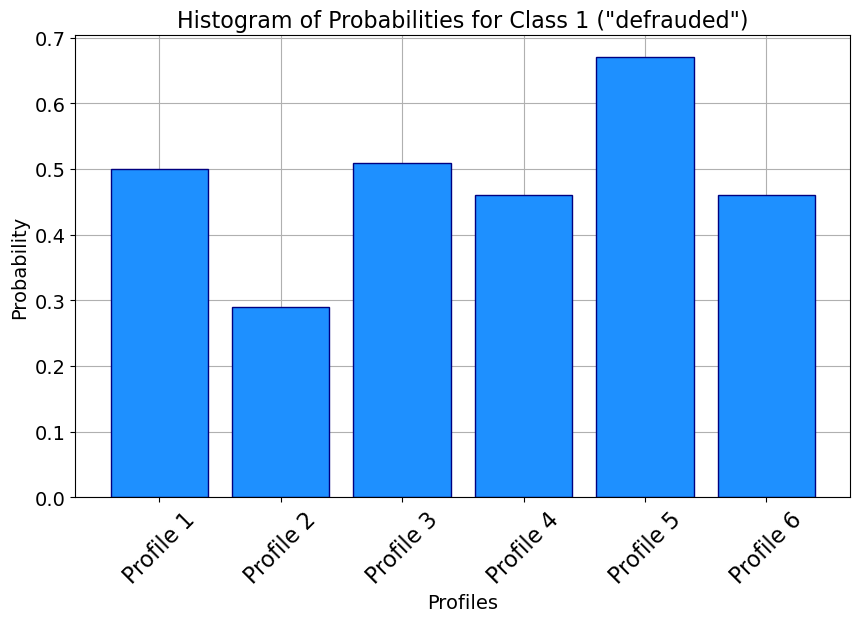

In [28]:
second_column=y_prob[:, 1]

x_labels=[f'Profile {i+1}' for i in range(len(second_column))]

plt.figure(figsize=(10, 6))
plt.bar(x_labels, second_column, color='dodgerblue', edgecolor='navy')
plt.xlabel('Profiles', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Histogram of Probabilities for Class 1 ("defrauded")', fontsize=16)
plt.xticks(rotation=45)  
plt.gca().set_axisbelow(True)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.savefig('ProfileProbs.png', dpi=300,  bbox_inches='tight')
plt.show()